## Model the disease states with multiple labels
achen@2021-5-20

In [1]:
import pandas as pd
import os
import glob
from Bio import Seq
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import re
from scipy.stats import wilcoxon,mannwhitneyu
import numpy as np

In [9]:
RSEED = 50
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
genomeInfo = pd.read_csv('../refs/136Fstrains/datalist.csv',sep='\t')
genomeSize = dict(genomeInfo.set_index("Assembly")['Size(Mb)'])

In [3]:
meta = pd.read_csv('../data/smp.count.txt',sep='\t')
meta['smp'] = meta['smp'].str.replace('_1P','')
smp2count = dict(meta.set_index('smp')['count'])
meta.head()

,smp,count
0,HD-29,18011389
1,LD-22,18011389
2,HD-52,18011389
3,LD-11,18011389
4,HD-31,18011389


In [139]:
genomeInfo = pd.read_csv('../refs/136Fstrains/datalist.csv',sep='\t')
genomeSize = dict(genomeInfo.set_index("Assembly")['Size(Mb)'])
max(genomeSize.values())

3.92898

In [147]:
import dask.dataframe as dd
from dask import delayed

def read_and_label_csv(filename):
    df_csv = pd.read_csv(filename,dtype={'best_mean_nm':str})
    df_csv['filename'] = os.path.basename(filename).replace('.csv','').replace('stat.','')
    
    df_csv['genome'] = df_csv.src.apply(lambda d: '_'.join(d.split('-')[2].split('_')[:2]))
    df_csv['abun'] = df_csv['best'] / (df_csv.filename.map(smp2count)*df_csv.genome.map(genomeSize))
    
    df_csv['abun'] = df_csv['abun']/df_csv['abun'].max()
    df_csv['sum-cov'] = df_csv['sum-cov']/100
    
    df_csv['mean_dep'] = df_csv['mean_dep']/df_csv['mean_dep'].max()

    return df_csv
fnames = glob.glob(f'../predict_cov//stats/*.csv')
dfs = [delayed(read_and_label_csv)(fname) for fname in fnames]
df = dd.from_delayed(dfs)
df = df.compute()
df['type'] = df['filename'].str[0]

In [148]:
%%time
arrs = []
smps = []
genomes = df.genome.unique()
for smp in df.filename.unique():
    #print(smp)
    smps.append(smp)
    arr = []
    for genome in genomes:
        tmpdf1 = df[df.filename==smp]
        tmpdf2 = tmpdf1[tmpdf1.src.str.contains(genome)]
        if len(tmpdf2)==0:
            arr += [0,0,0]
            #arr += [0]
        else:
            # include them all
            a = tmpdf2.reset_index(drop=True).loc[0]['sum-cov']
            b = tmpdf2.reset_index(drop=True).loc[0]['mean_dep']
            c = tmpdf2.reset_index(drop=True).loc[0]['abun']
            arr += [a,b,c]
            #arr += [c]
    arrs.append(arr)
    
row_names=  []
for genome in genomes:
    row_names += [f'{genome}-cov',f'{genome}-dep',f'{genome}-abun']
    #row_names += [f'{genome}-cov']

CPU times: user 1min 55s, sys: 38.7 ms, total: 1min 55s
Wall time: 1min 55s


In [149]:
covdf = pd.DataFrame(arrs)
covdf['smp'] = smps
covdf = covdf.set_index('smp')
covdf.columns = row_names
covdf['y'] = covdf.index.str[0].map({'H':0,'L':1})

In [150]:
covdf.head()

,GCA_008680095.1-cov,GCA_008680095.1-dep,GCA_008680095.1-abun,GCA_003467805.1-cov,GCA_003467805.1-dep,GCA_003467805.1-abun,GCA_003433995.1-cov,GCA_003433995.1-dep,GCA_003433995.1-abun,GCA_003465525.1-cov,...,GCA_004558805.1-cov,GCA_004558805.1-dep,GCA_004558805.1-abun,GCA_002313795.1-cov,GCA_002313795.1-dep,GCA_002313795.1-abun,GCA_002404655.1-cov,GCA_002404655.1-dep,GCA_002404655.1-abun,y
smp,,,,,,,,,,,,,,,,,,,,,
HD-29,0.784699,1.000000,1.000000,0.767453,0.979284,0.971081,0.759625,0.721769,0.691609,0.712790,...,0.082898,0.124269,0.064303,0.024340,0.057204,0.015991,0.023705,0.037806,0.011975,0
HD-31,0.086319,0.095528,0.093297,0.093557,0.192043,0.110233,0.604672,0.843166,0.798804,0.100727,...,0.026793,0.169805,0.026844,0.012415,0.049673,0.012184,0.012729,0.038080,0.010675,0
LD-16,0.708459,0.961404,0.982684,0.713414,1.000000,1.000000,0.693037,0.248689,0.242448,0.667599,...,0.059436,0.082833,0.040277,0.026976,0.040568,0.009099,0.027437,0.014722,0.007076,1
LD-22,0.715225,0.606526,0.641902,0.722149,0.658804,0.688917,0.724559,0.590453,0.585900,0.682830,...,0.077442,0.150333,0.051362,0.018129,0.045933,0.010241,0.018680,0.022428,0.007780,1
LD-26,0.382886,0.080043,0.086671,0.398907,0.126191,0.114277,0.787735,1.000000,1.000000,0.399488,...,0.029458,0.033000,0.007911,0.021037,0.028881,0.008127,0.021106,0.012871,0.006022,1


In [99]:
def cv_auc(estimator,paras,rseed,df,x_columns,y_column,method='rf',n_iter=100,n_splits=5,verbose = 1,shuffle=True):
    
    X = df[x_columns].to_numpy()
    y = df[y_column].to_numpy()
    
    merge_fi = pd.DataFrame()
    feat = None
    i = -1
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    plt.figure(figsize=(8,6))
    fig, ax = plt.subplots(figsize=(8,6))
    
    for train_id,test_id in KFold(n_splits=n_splits,shuffle=shuffle).split(range(len(X))):
        i += 1
        x_train = X[train_id]
        y_train = np.array(y)[train_id]
        
        x_test = X[test_id]
        y_test = np.array(y)[test_id]
        
        # Create the random search model
        rs = RandomizedSearchCV(estimator, paras, n_jobs = -1, 
                                #scoring = 'roc_auc', cv = 3, 
                                #n_iter = 10, verbose = 1, random_state=RSEED)
                                scoring = 'roc_auc', cv = 3, 
                                n_iter = n_iter, verbose = verbose, random_state=rseed)
        
        rs.fit(x_train, y_train)
        best_model = rs.best_estimator_
        
        train_rf_predictions = best_model.predict(x_train)
        train_rf_probs = best_model.predict_proba(x_train)[:, 1]
        
        rf_predictions = best_model.predict(x_test)
        rf_probs = best_model.predict_proba(x_test)[:, 1]
        
        if method == 'rf': 
            fi = pd.DataFrame({'feature': x_columns,
                           'importance': best_model.feature_importances_}).\
                            sort_values('importance', ascending = False)
            fi['batch'] = i
            merge_fi = pd.concat([merge_fi,fi])
        
        pred_test = best_model.predict_proba(x_test)[:,1]
        #fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, pred_test, pos_label=1)
        
        viz = plot_roc_curve(best_model, x_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    if method == 'rf':
        feat = merge_fi.groupby('feature').agg({'importance':np.mean}).sort_values(by='importance',ascending=False)       
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    
    return mean_auc,feat
    
        

<Figure size 576x432 with 0 Axes>

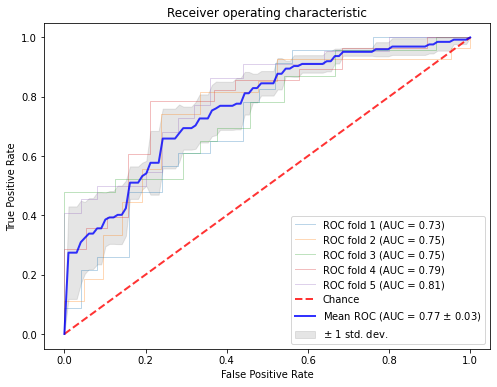

0.7651003415166788


In [144]:
param_svm = {'C': loguniform(1e0, 1e3),
 'gamma': loguniform(1e-4, 1e-3),
 'kernel': ['rbf','linear'],
 'class_weight':['balanced', None]}

svc = svm.SVC(probability=True)
mean_auc,feat = cv_auc(svc,param_svm,RSEED,covdf,covdf.columns.drop('y'),'y',method='svm',n_iter=100,n_splits=5,verbose=0,shuffle=True)
print(mean_auc)

<Figure size 576x432 with 0 Axes>

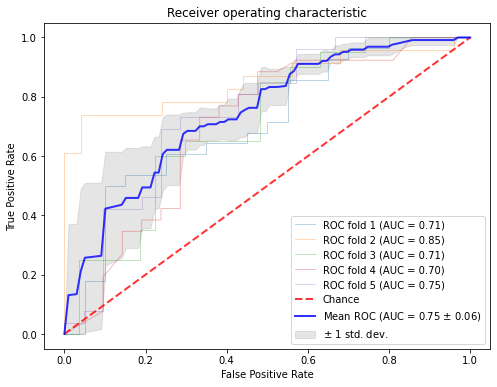

0.7452491031147157


In [145]:
param_rf = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
rf_estimator = RandomForestClassifier(random_state = RSEED)

mean_auc,feat = cv_auc(rf_estimator,param_grid,RSEED,covdf,covdf.columns.drop('y'),'y',n_iter=100,n_splits=5,verbose=0,shuffle=True)

print(mean_auc)

In [146]:
feat

,importance
feature,
GCA_001406615.2-cov,0.061392
GCA_014868915.1-dep,0.056193
GCA_001916555.1-dep,0.029569
GCA_002549905.1-dep,0.029135
GCA_000166035.1-dep,0.019116
...,...
GCA_003434135.1-dep,0.000000
GCA_003434135.1-abun,0.000000
GCA_003434125.1-cov,0.000000


In [127]:
%%capture

stat_arr = []
models = []
for method in ['svm','rf']:
    for col in ['cov','dep','abun','all']:
        print(f'{method}-{col}')
        
        if col == 'all':
            x_columns = covdf.columns.drop('y')
        else:
            x_columns = covdf.columns[covdf.columns.str.contains(col)]
        y_columns = 'y'
        if method == 'svm':
            paras = param_svm
            estimator = svm.SVC(probability=True,random_state = RSEED)
        elif method == 'rf':
            paras = param_rf      
            estimator = RandomForestClassifier(random_state = RSEED)
        i = -1
        while(i<20):
            i+=1
            mean_auc,feat = cv_auc(estimator,paras,RSEED,covdf,x_columns,y_columns,method=method,n_iter=100,n_splits=5,verbose=0,shuffle=True)
            plt.savefig(f'figures/{method}-{col}-{i}-AUC{round(mean_auc)}.png')
            stat_arr.append([method,col,mean_auc])
            models.append(estimator)

            

In [151]:
tmpdf = pd.DataFrame(stat_arr,columns=['methods','inputs','auc'])
tmpdf

,methods,inputs,auc
0,svm,cov,0.760618
1,svm,cov,0.746480
2,svm,cov,0.771605
3,svm,cov,0.774904
4,svm,cov,0.768224
...,...,...,...
163,rf,all,0.696703
164,rf,all,0.714628
165,rf,all,0.690598
166,rf,all,0.686511


In [155]:
tmpdf[(tmpdf['inputs']=='cov')&(tmpdf['methods']=='svm')]['auc'].median()

0.7698947995648131

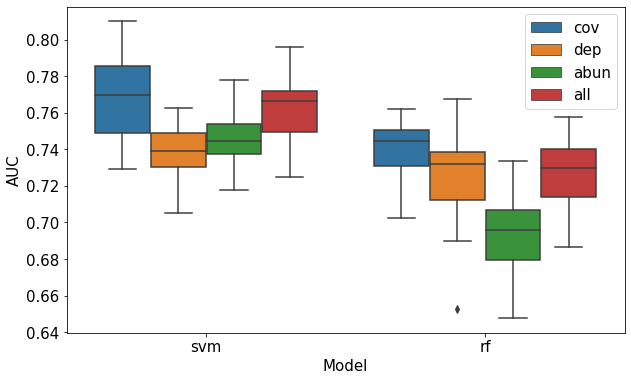

In [136]:
plt.figure(figsize=(10,6))

sns.boxplot(data=tmpdf,x='methods',y='auc',hue='inputs')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Model',fontsize=15)
plt.ylabel('AUC',fontsize=15)
plt.legend(fontsize=15)


<Figure size 576x432 with 0 Axes>

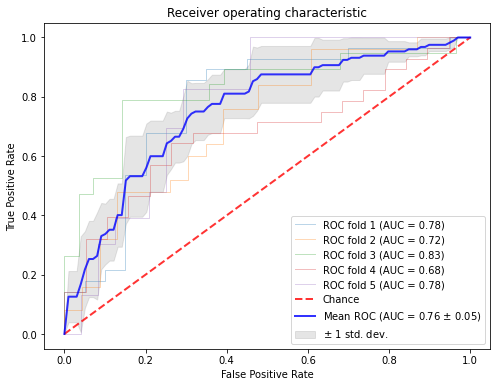

0.7550396676803999


In [248]:
#param_svm = {'C': loguniform(1e0, 1e3),
# 'gamma': loguniform(1e-4, 1e-3),
# 'kernel': ['rbf','linear'],
# 'class_weight':['balanced', None]}

param_svm = {'C': loguniform(1e0,1e3),
 'gamma': ['scale'],
 'kernel': ['rbf'],
 'class_weight':['balanced', None]}

svc = svm.SVC(probability=True)
xcols = ['GCA_001406615.2-cov']
ycols = 'y'
mean_auc,feat = cv_auc(svc,param_svm,RSEED,covdf,xcols,ycols,method='svm',n_iter=100,n_splits=5,verbose=0,shuffle=True)
print(mean_auc)

<Figure size 576x432 with 0 Axes>

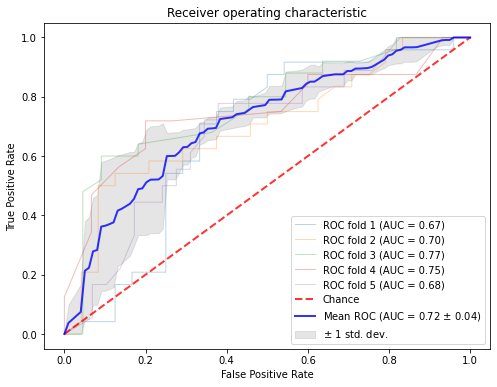

0.7150169122481833


In [262]:
param_rf = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

rf_estimator = RandomForestClassifier(random_state = RSEED)
#rf_estimator = RandomForestClassifier()
xcols = ['GCA_001406615.2-cov']
ycols = 'y'
mean_auc,feat = cv_auc(rf_estimator,param_grid,RSEED,covdf,xcols,ycols,n_iter=100,n_splits=5,verbose=0,shuffle=True)
print(mean_auc)

<Figure size 576x432 with 0 Axes>

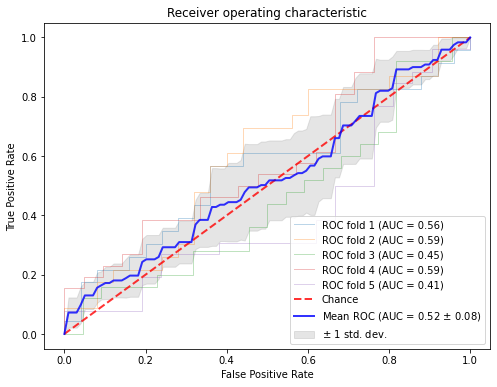

0.5213154960981048


In [265]:
param_svm = {'C': loguniform(1e0,1e3),
 'gamma': ['scale'],
 'kernel': ['rbf'],
 'class_weight':['balanced', None]}

svc = svm.SVC(probability=True)
xcols = ['GCA_902388275.1-cov']
ycols = 'y'
mean_auc,feat = cv_auc(svc,param_svm,RSEED,covdf,xcols,ycols,method='svm',n_iter=100,n_splits=5,verbose=0,shuffle=True)
print(mean_auc)

<Figure size 576x432 with 0 Axes>

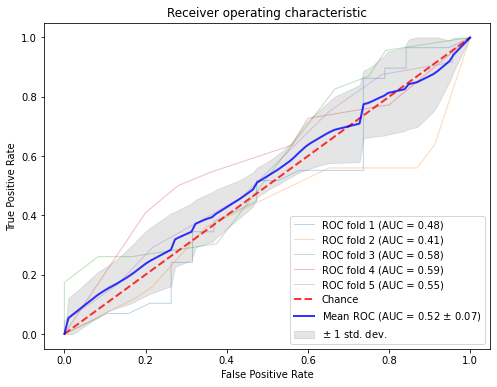

0.521562476611079


In [268]:
param_rf = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

rf_estimator = RandomForestClassifier(random_state = RSEED)
#rf_estimator = RandomForestClassifier()
xcols = ['GCA_902388275.1-cov']
ycols = 'y'
mean_auc,feat = cv_auc(rf_estimator,param_grid,RSEED,covdf,xcols,ycols,n_iter=100,n_splits=5,verbose=0,shuffle=True)
print(mean_auc)

<AxesSubplot:xlabel='type', ylabel='GCA_902388275.1-cov'>

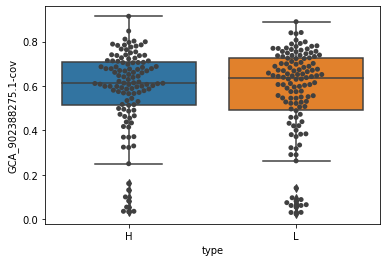

In [38]:
sns.boxplot(data=pltdf,y='GCA_902388275.1-cov',x='type')
sns.swarmplot(data=pltdf,y='GCA_902388275.1-cov',x='type',color='0.25')